In [367]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import datetime


In [368]:
# Define some constants
latitude = [40.79736, 41.78701, 30.1444, 25.7738]
longitude = [-73.97785, -87.77166, -97.66876, -80.1936]
cities = ["ny", "il", "tx", "fl"]
start_date = "2016-01-01"
end_date = "2024-03-20"

In [369]:
# Step 1: Load your data
# Assume 'df' is your DataFrame with columns 'date', 'day_of_year', 'tmax', 'tmin', 'precipitation', 'humidity'
df = pd.read_pickle("./data_cleaned_"+ "ny" +".pkl")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# df.loc[datetime.datetime(2016, 1, 1), datetime.datetime(2024, 2, 29)]
df

tmax_vc    tmax_om  tmax_ms  humi_vc  prec_om  tmin_ms  day  \
date                                                                      
2020-01-15     50.2  48.727398    50.00     66.4      3.0    42.80   15   
2020-01-16     48.2  47.647400    48.20     63.7      8.0    33.80   16   
2020-01-17     34.1  36.757400    33.80     36.0      0.0    21.20   17   
2020-01-18     37.1  32.797400    37.40     60.2      6.0    19.40   18   
2020-01-19     42.4  44.227400    42.80     62.2      7.0    28.40   19   
...             ...        ...      ...      ...      ...      ...  ...   
2024-03-16     60.5  57.727398    60.98     52.9      0.0    43.34   76   
2024-03-17     61.8  59.887400    62.06     43.6      2.0    48.38   77   
2024-03-18     49.4  49.897400    48.92     37.2      0.0    39.20   78   
2024-03-19     47.3  45.217400    45.50     42.7      0.0    35.60   79   
2024-03-20     55.6        NaN    53.60     51.5      0.0    34.70   80   

             tmax_avg  tmin_avg  
date                             
2020-01-15  49.642466     42.80  
2020-01-16  48.015800     33.80  
2020-01-17  34.885800     21.20  
2020-01-18  35.765800     19.40  
2020-01-19  43.142467     28.40  
...               ...       ...  
2024-03-16  59.735799     43.34  
2024-03-17  61.249133     48.38  
2024-03-18  49.405800     39.20  
2024-03-19  46.005800     35.60  
2024-03-20  54.600000     34.70  

[1458 rows x 9 columns]

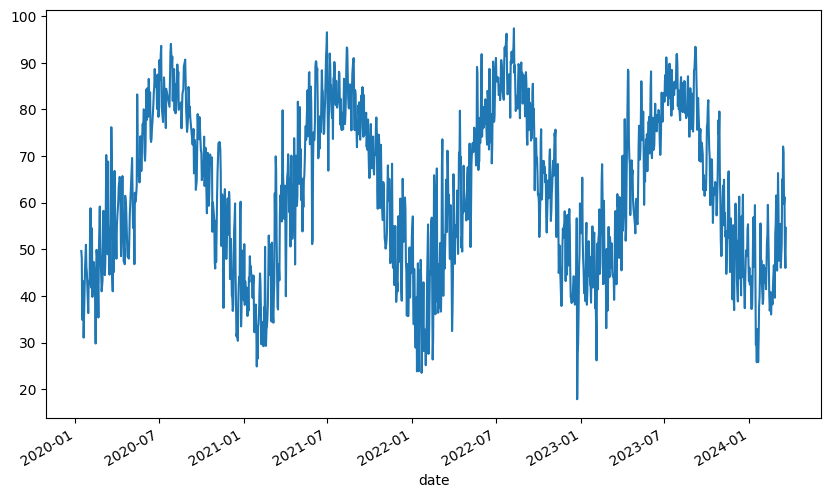

In [370]:
df['tmax_avg'].plot(figsize=(10,6))
plt.show()


In [371]:
df = df.rename(columns={"day": "day_of_year", "tmax_avg":"tmax", "tmin_avg": "tmin", 'prec_om': "prec", 'humi_vc': "humi"})
df.info()
features = ['day_of_year', 'tmax', 'tmin', 'prec', 'humi']
df = df[features]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1458 entries, 2020-01-15 to 2024-03-20
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tmax_vc      1458 non-null   float64
 1   tmax_om      1457 non-null   float64
 2   tmax_ms      1458 non-null   float64
 3   humi         1458 non-null   float64
 4   prec         1458 non-null   float64
 5   tmin_ms      1458 non-null   float64
 6   day_of_year  1458 non-null   int32  
 7   tmax         1458 non-null   float64
 8   tmin         1458 non-null   float64
dtypes: float64(8), int32(1)
memory usage: 108.2 KB


In [372]:
df

day_of_year       tmax   tmin  prec  humi
date                                                 
2020-01-15           15  49.642466  42.80   3.0  66.4
2020-01-16           16  48.015800  33.80   8.0  63.7
2020-01-17           17  34.885800  21.20   0.0  36.0
2020-01-18           18  35.765800  19.40   6.0  60.2
2020-01-19           19  43.142467  28.40   7.0  62.2
...                 ...        ...    ...   ...   ...
2024-03-16           76  59.735799  43.34   0.0  52.9
2024-03-17           77  61.249133  48.38   2.0  43.6
2024-03-18           78  49.405800  39.20   0.0  37.2
2024-03-19           79  46.005800  35.60   0.0  42.7
2024-03-20           80  54.600000  34.70   0.0  51.5

[1458 rows x 5 columns]

In [373]:
df
data = df

In [374]:
target = 'tmax'

# Normalize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

In [375]:
# Function to create a dataset for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


In [376]:
time_steps = 60  # Use 10 days of data to predict the next day's 'tmax'
X, y = create_dataset(df_scaled, df_scaled[:, 1], time_steps)
split = int(len(X) * 0.75)  # 70% for training

# Split the data
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [377]:
# LSTM model
model = Sequential()
model.add(LSTM(70, activation='relu', input_shape=(time_steps, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')


/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [378]:
# Train the model
model.fit(X_train, y_train, epochs=47, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.7271 - val_loss: 0.2397
Epoch 2/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2117 - val_loss: 0.2033
Epoch 3/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1794 - val_loss: 0.1946
Epoch 4/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1754 - val_loss: 0.1927
Epoch 5/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1711 - val_loss: 0.1826
Epoch 6/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1715 - val_loss: 0.1779
Epoch 7/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1581 - val_loss: 0.1663
Epoch 8/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1540 - val_loss: 0.1883
Epoch 9/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1646 - val_loss: 0.1587
Epoch 10/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1539 - val_loss: 0.1552
Epoch 11/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1356 - val_loss: 0.1607
Epoch 12/47
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1

In [379]:
# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print(f'Test MSE: {mse}')

# Predictions
predictions = model.predict(X_test)

Test MSE: 0.11849245429039001
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [380]:
df_scaled[-5:]

array([[-0.94237274, -0.17303428, -0.38425312, -0.69282332, -0.51526352],
       [-0.93307999, -0.08357369, -0.06520275, -0.32375631, -1.11666007],
       [-0.92378724, -0.78369122, -0.6463302 , -0.69282332, -1.53052435],
       [-0.91449449, -0.9846819 , -0.87422331, -0.69282332, -1.17485973],
       [-0.90520174, -0.47663658, -0.93119659, -0.69282332, -0.60579634]])

In [381]:
# df.iloc[-time_steps:]

In [382]:
# Prepare the input data for March 9, 2024
# This is an example array where you need to replace it with actual data from Feb 27, 2024, to March 8, 2024.
# Each row in `last_days_data` corresponds to a day, with columns for 'day_of_year', 'tmax', 'tmin', 'prec', 'humi'.
last_days_data = np.array(df[-(time_steps-1):])
# print(last_days_data)
# Normalize the input data using the same scaler used for the training data
last_days_scaled = scaler.transform(last_days_data)

# Reshape the data to match the input shape of the LSTM model: (1, time_steps, num_features)
last_days_scaled = np.expand_dims(last_days_scaled, axis=0)

# Predict the scaled 'tmax' for March 9, 2024
predicted_tmax_scaled = model.predict(last_days_scaled)

# Inverse transform the scaled prediction to get the actual temperature
# predicted_tmax = scaler.inverse_transform(np.concatenate((np.zeros((predicted_tmax_scaled.shape[0], df_scaled.shape[1]-1)), predicted_tmax_scaled), axis=1))[:, 1]
# Step 1: Create a dummy array with the same structure as the training data
dummy_array = np.zeros((1, len(features)))  # 'features' should include all features used during scaling

# Step 2: Replace the 'tmax' values in the dummy array with your predictions
# Assuming 'tmax' was the second feature during scaling
dummy_array[:, 1] = predicted_tmax_scaled  # Replace '1' with the correct index of 'tmax' in your features

# Step 3: Apply the inverse transformation
inverse_transformed_array = scaler.inverse_transform(dummy_array)

# Step 4: Extract the inverse-transformed 'tmax' values
predicted_tmax = inverse_transformed_array[:, 1]  # Use the correct index for 'tmax'

print(predicted_tmax)
print(f"Predicted 'tmax' for next day: {predicted_tmax[0]}")

/opt/miniconda3/envs/cs542/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
[56.71067161]
Predicted 'tmax' for next day: 56.71067161484735


In [383]:
# # Initialize the input with the last known data
# # Replace `last_days_data` with the actual last `time_steps` days from your dataset
# last_days_data = np.array(df[-time_steps:])

# # Normalize the input data
# last_days_scaled= scaler.transform(last_days_data)


In [384]:

# # Prepare to collect predictions
# predictions = []

# for i in range(10):
#     # Initialize the input with the last known data
#     # Replace `last_days_data` with the actual last `time_steps` days from your dataset
#     last_days_data = np.array(df[-time_steps+i:])

#     # Normalize the input data
#     last_days_scaled= scaler.transform(last_days_data)
#     # Use the last_days_scaled for prediction
#     X_pred = np.expand_dims(last_days_scaled, axis=0)
#     predicted_tmax_scaled = model.predict(X_pred)[0, 0]  # Predicted 'tmax' in scaled form

#     # Shift the window: drop the oldest day, append the most recent day (including the predicted 'tmax')
#     last_days_scaled = np.roll(last_days_scaled, -1, axis=0)
#     # Update the last day's data with the newly predicted 'tmax' (scaled)
#     # Note: You might also update other features here based on expected changes or correlations
#     last_days_scaled[-1, 1] = predicted_tmax_scaled  # Assuming 'tmax' is at index 1
#     print(predicted_tmax_scaled)

#     # Inverse scale the predicted 'tmax' to add it to the predictions list
#     # Step 1: Create a dummy array with the same structure as the training data
#     dummy_array = np.zeros((1, len(features)))  # 'features' should include all features used during scaling

#     # Step 2: Replace the 'tmax' values in the dummy array with your predictions
#     # Assuming 'tmax' was the second feature during scaling
#     dummy_array[:, 1] = predicted_tmax_scaled  # Replace '1' with the correct index of 'tmax' in your features

#     # Step 3: Apply the inverse transformation
#     inverse_transformed_array = scaler.inverse_transform(dummy_array)

#     # Step 4: Extract the inverse-transformed 'tmax' values
#     predicted_tmax = inverse_transformed_array[:, 1]  # Use the correct index for 'tmax'

#     predictions.append(predicted_tmax)

# # Print or return the predictions
# for i, pred in enumerate(predictions, 1):
#     print(f"Day {i}: Predicted 'tmax' = {pred}")
